# Contents
1) create a search table with key=term and value paragragh in raw LaTeXML output

2) a term-reference is {term, art_addr, parag_index, p_tag, tfidf}

3) serialize the list of term-references with the split files from Bridges-2

4) Uploading to AWS database, this includes using boto3, dynamodb SDK

TODO:
- Some `<para>` tags don't have a `<p>` inside so I just used recutext. *ADD* the missing p tag

In [92]:
from lxml import etree
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import glob
from tqdm import tqdm
from sklearn import linear_model
import tarfile
from tqdm import tqdm
from marshmallow import Schema, fields, pprint
from random import random
from dataclasses import dataclass, field
from sklearn.feature_extraction.text import TfidfVectorizer
import boto3 as b3
import botocore as bcore
from enum import Enum
import re
from bs4 import BeautifulSoup

import json

import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, os.path.join(parentdir, 'embed'))
sys.path.insert(0, parentdir)
sys.path.insert(0, os.path.join(parentdir, 
                "slurm_scripts/termreference_db"))

%load_ext autoreload
%autoreload 2

from clean_and_token_text import normalize_text, normalize_phrase, join_xml_para_and_write, ReadGlossary
import parsing_xml as px
import peep_tar as peep
import upload_termrefs_to_dynamodb as updyn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
general_path = 'math20/2003_003'
argot_path = '/media/hd1/glossary/NN.v1/' + general_path + '.xml.gz'
prom_path = '/media/hd1/promath/' + general_path + '.tar.gz'
join_path = '/media/hd1/cleaned_text/joined_math12-34_04-01/' + general_path + 'xml.gz'
ns = {'latexml': 'http://dlmf.nist.gov/LaTeXML' }

argot = etree.parse(argot_path)
with tarfile.open(prom_path) as tar_fobj:
    art_lst = [k.get_info()['name'] for k in tar_fobj.getmembers()]
    members = tar_fobj.getmembers()

In [18]:
#glossary_file_lst = glob.glob('/media/hd1/glossary/NN.v1/math9*/*.xml.gz')
glossary_file_lst = glob.glob('/media/hd1/glossary/NN.v1/math0*/*.xml.gz')

RG = ReadGlossary('/media/hd1/glossary/v3/math*/*.xml.gz', '/media/hd1/glossary/NN.v1/math*/*')
vocab = RG.ntc_intersect('relative')

corpus = []
term_ref_lst = []
for glossary_file in tqdm(glossary_file_lst):
    # argot_file format: /media/hd1/glossary/NN.v1/math95/9506_001.xml.gz
    math_year = glossary_file.split('/')[-2]
    subfilename = glossary_file.split('/')[-1].split('.')[0] # should be 9506_001
    promath_file = os.path.join('/media/hd1/promath', math_year, subfilename + '.tar.gz')
    joined_file = os.path.join('/media/hd1/cleaned_text/joined_math19-35_13-01/',
                               math_year, subfilename + '.xml.gz')
    
    glossary_xml = etree.parse(glossary_file)
    joined_xml = etree.parse(joined_file)
    promath_tarfobj = tarfile.open(promath_file)
    for art in glossary_xml.findall('./article'):
        art_name = art.get('name')
        # need to use only the basename of the article
        #art_basename = os.path.basename(art_name)
        joined_name_results = joined_xml.xpath('./article[@name="{}"]'.format(art_name))
        # POPULATE THE CORPUS
        if len(joined_name_results) > 0:
            joined_art_text = ''
            for parag in joined_name_results[0].findall('./parag'):
                text = '' if parag.text is None else parag.text
                joined_art_text += (text + ' ')
            corpus.append(joined_art_text)
        else:
            print(f'joined name search results empty art_name={art_name}')
            corpus.append('')
        corpus_index = len(corpus) - 1
        
        # OPEN THE PROMATH FILE
        try:
            #promath_obj = peep.tar(promath_file, art_name)[1].exml
            promath_obj = px.DefinitionsXML(promath_tarfobj.extractfile(art_name))
        except AttributeError:
            print(f'{art_name} gave attributeError')
        # this list is in sync with glossary paragraph index
        promath_parag_lst = promath_obj.para_list()
        
        # LOOP THROUGH THE DFDUMS
        for defin in art.findall('./definition'):
            p_index = int(defin.get('index'))
            for term_raw in defin.findall('./dfndum'):
                term = normalize_text(term_raw.text)
                if term in vocab:
                    term_ref_lst.append((
                           term,
                            art_name,
                            p_index,
                            etree.tostring(promath_parag_lst[p_index]).decode('utf-8'),
                            corpus_index))
    promath_tarfobj.close()

  1%|          | 21/2816 [00:00<00:16, 172.08it/s]

found [2816, 2816] files


100%|██████████| 240/240 [1:06:37<00:00, 16.66s/it]


In [79]:
pickle_data_path = '/media/hd1/termreferences/termreference_db17-33_22-01/'
with open(pickle_data_path + 'split_pickles/ter_03.pickle', 'rb') as fobj:
    term_ref_lst = pickle.load(fobj)
#with open(pickle_data_path + 'vocab.pickle', 'rb') as fobj:
#    vocab = pickle.load(fobj)
#with open(pickle_data_path + 'corpus.pickle', 'rb') as fobj:
#    corpus = pickle.load(fobj)
#with open(pickle_data_path + 'ttrans.pickle', 'rb') as fobj:
#    ttrans = pickle.load(fobj)
#with open(pickle_data_path + 'vocab_fixed.pickle', 'rb') as fobj:
#    vocab_ = pickle.load(fobj)

In [4]:
%%script echo esto tarda 11 min
# COMPUTE THE TDIDF MATRIX
vocab_ = list(set([t.replace(' ', '_') for t in vocab]))
tvect = TfidfVectorizer(sublinear_tf=True, norm='l1', vocabulary=vocab_)
                
%time ttrans = tvect.fit_transform(corpus)
print(f'The shape of the resulting matrix is: {ttrans.shape}')

with open(pickle_data_path + 'ttrans.pickle', 'wb') as fobj:
    pickle.dump(ttrans, fobj)
    
with open(pickle_data_path + 'vocab_fixed.pickle', 'wb') as fobj:
    pickle.dump(vocab_, fobj)

esto tarda 11 min


In [32]:
def get_tfidf(term_, corpus_index_, vocab_):
    ter = term_.replace(' ', '_')
    tindex = vocab_.index(ter)
    x = ttrans[corpus_index_, tindex]
    return int(x * 10_000_000_000)

get_tfidf('vertex_of', 315652, vocab_)

76347426

In [56]:
## MAKING QUERIES
def get_movie(truid, tfidf, dynamodb=None):
    if not dynamodb:
        dynamodb = b3.resource('dynamodb', endpoint_url="http://localhost:8000")

    table = dynamodb.Table('TermReference2')

    try:
        response = table.get_item(Key={'truid': truid, "tfidf": tfidf})
    except bcore.exceptions.ClientError as e:
        print(e.response['Error']['Message'])
    else:
        return response['Item']

#res = get_movie(3, 24440)
#pprint(res)

def query_termreference(term, dynamodb=None, table="TermReference"):
    """
    Finds an exact truid
    """
    if not dynamodb:
        dynamodb = boto3.resource('dynamodb', endpoint_url="http://localhost:8000")

    table = dynamodb.Table(table)
    response = table.query(
        KeyConditionExpression=b3.dynamodb.conditions.Key('truid').eq(truid)
    )
    return response['Items']

#res = query_termreference(1005)
#pprint(res)
#ddb = b3.resource('dynamodb', endpoint_url="http://localhost:8000")
ddb = b3.resource('dynamodb', region_name="us-east-2")
tab = ddb.Table('TermReference')
response = tab.query(
    KeyConditionExpression=b3.dynamodb.conditions.Key('term')\
    .eq('lie group'),
    ScanIndexForward=False,
    Limit=10,
)
[(r['addr'],r['tfidf']) for r in response['Items']]

[('0612_002/math.0612182/math.0612182.xml', Decimal('125017599')),
 ('1304_007/1304.4667/1304.4667.xml', Decimal('106511551')),
 ('0711_002/0711.2775/0711.2775.xml', Decimal('95227573')),
 ('0806_002/0806.2547/0806.2547.xml', Decimal('88469028')),
 ('1305_005/1305.2855/1305.2855.xml', Decimal('77125635')),
 ('1411_002/1411.0803/1411.0803.xml', Decimal('73479893')),
 ('0205_001/math.0205252/math.0205252.xml', Decimal('72581675')),
 ('0809_002/0809.2806/0809.2806.xml', Decimal('72452075')),
 ('0809_002/0809.2806/0809.2806.xml', Decimal('72452073')),
 ('0611_002/math.0611431/PedramHekmati.xml', Decimal('62418890'))]

In [33]:
# LIST ALL TABLES
#dcl = b3.client('dynamodb', endpoint_url='http://localhost:8000')
#dcl.list_tables()['TableNames']

# DELETE A TABLE
#ddb = b3.resource('dynamodb', endpoint_url='http://localhost:8000')
#table = ddb.Table('TermReference')
#table.delete()

# SCAN A TABLE
#ddb = b3.resource('dynamodb', endpoint_url='http://localhost:8000')
#table = ddb.Table('TermReference')
#table.item_count

{'TableDescription': {'AttributeDefinitions': [{'AttributeName': 'term',
    'AttributeType': 'S'},
   {'AttributeName': 'tfidf', 'AttributeType': 'N'}],
  'TableName': 'TermReference',
  'KeySchema': [{'AttributeName': 'term', 'KeyType': 'HASH'},
   {'AttributeName': 'tfidf', 'KeyType': 'RANGE'}],
  'TableStatus': 'ACTIVE',
  'CreationDateTime': datetime.datetime(2022, 1, 29, 12, 58, 41, 393000, tzinfo=tzlocal()),
  'ProvisionedThroughput': {'LastIncreaseDateTime': datetime.datetime(1969, 12, 31, 19, 0, tzinfo=tzlocal()),
   'LastDecreaseDateTime': datetime.datetime(1969, 12, 31, 19, 0, tzinfo=tzlocal()),
   'NumberOfDecreasesToday': 0,
   'ReadCapacityUnits': 10,
   'WriteCapacityUnits': 10},
  'TableSizeBytes': 494142148,
  'ItemCount': 46998,
  'TableArn': 'arn:aws:dynamodb:ddblocal:000000000000:table/TermReference'},
 'ResponseMetadata': {'RequestId': 'd5294f7d-dadc-4afc-9570-61f92d30b83d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 29 Jan 2022 20:04:28 GMT',
   'con

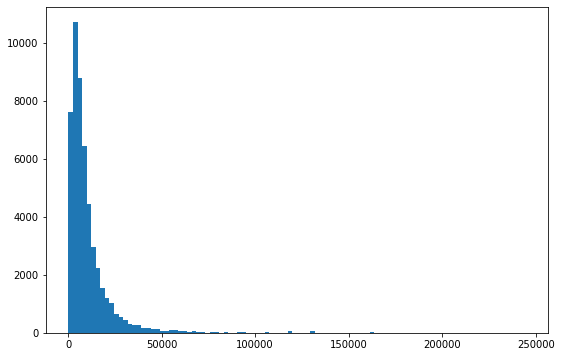

In [109]:
plt.figure(figsize=[9,6])
ax = plt.subplot(111)
plt.hist([len(tr.p_tag) for tr in TR_lst],100)
#ax.get_yaxis().set_major_formatter(
#    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [187]:
# check if it is possible to find the same paragraph in promath, argot-glossary, joined
def check_sync(parag_index, art_ind_in_argot, general_path_):
    argot_path = '/media/hd1/glossary/NN.v1/' + general_path_ + '.xml.gz'
    prom_path = '/media/hd1/promath/' + general_path_ + '.tar.gz'
    join_path = '/media/hd1/cleaned_text/joined_math12-34_04-01/' +\
                                general_path_ + '.xml.gz'
    
    # first get the paragraph index from argot
    argot_xml = etree.parse(argot_path)
    article_ind = argot_xml.getroot()[art_ind_in_argot]
    argot_def = article_ind[parag_index]
    article_name = article_ind.get('name')
    print(f'------------ ARGOT {article_name} -------------- ')
    print(etree.tostring(argot_def))
    parag_ind = int(argot_def.get('index'))
    
    #for k,tarobj in enumerate(peep.tar_iter(prom_path, '.xml')):
    #    if k == art_ind_in_argot:
    
    #promath_obj = etree.parse(tarobj[1])
    promath_obj = peep.tar(prom_path, article_name)[1].exml
    parag = promath_obj.findall('.//latexml:para', namespaces=ns)[parag_ind]
    print('-------------- PROMath ------------')
    print(px.recutext_xml(parag))
    
    joined_xml = etree.parse(join_path)
    art_basename = article_name.split('/')[-1]
    joined_ind = joined_xml.xpath('./article[@name="{}"]'.format(art_basename))[0]
    joined_para = joined_ind[parag_ind]
    article_name_in_join = joined_ind.get('name')
    print(f'---------------- JOINED {article_name_in_join}---------------')
    print(etree.tostring(joined_para))
            
check_sync(1, 5, 'math95/9505_001')

------------ ARGOT 9505_001/math.9505216/math.9505216.xml -------------- 
b'<definition index="15">\n      <stmnt> Given _inline_math_, _inline_math_ is in _inline_math_ if the following is true. _inline_math_ is a disjoint decomposition. _inline_math_ and _inline_math_ are in _inline_math_ where _inline_math_, _inline_math_. There is _inline_math_, an isomorphism between _inline_math_ and _inline_math_. _inline_math_ is the identity. For _inline_math_ the sets _inline_math_ and _inline_math_ are isomorphic. _inline_math_. _inline_math_ is one-to-one and takes only values outside _inline_math_ (which is the same as _inline_math_). _inline_math_. We make _inline_math_ and the ordering on _inline_math_ is the one generated by this. </stmnt>\n    <dfndum>disjoint decomposition</dfndum><dfndum>isomorphic</dfndum><dfndum>one-to-one</dfndum></definition>\n  '
-------------- PROMath ------------
 Given _inline_math_, _inline_math_ is in _inline_math_ if the following is true. _inline_math_ is

In [17]:
# Define a dictionary Key=term and Value=(article_address, parag_index)
#results = argot.xpath(".//dfndum[text()='isothermic']")
#results = argot.xpath(".//dfndum[contains(text(),'quan')]")
results = argot.xpath(".//dfndum")
term_pair_dict = defaultdict(list)
for r in results:
    parent = r.getparent()
    para_index = int(parent.get('index'))
    grand_parent = parent.getparent()
    gparent_name = grand_parent.get('name')
    term_pair_dict[normalize_phrase(r.text)].append((gparent_name, para_index))
    
term_para_dict = defaultdict(list)
with tarfile.open(prom_path) as tar_fobj:
    for term, pair_lst in tqdm(term_pair_dict.items()):
        for pair in pair_lst:
            xml_fobj = tar_fobj.extractfile(pair[0])
            art = etree.parse(xml_fobj)
            para_lst = art.findall('.//latexml:para', namespaces=ns)
            para_tag = para_lst[pair[1]]
            try:
                #p_tag = etree.tostring(
                #    para_tag.find('.//latexml:p', namespaces=ns)).decode('utf-8').strip()
                p_tag = etree.tostring(
                         para_tag).decode('utf-8').strip()
            except TypeError as e:
                p_tag = px.recutext_xml(para_tag)
                print(e)
            term_para_dict[term].append((*pair, p_tag))
    

100%|██████████| 575/575 [01:08<00:00,  8.37it/s]


In [16]:
def get_para(art_addr, para, tar_path=prom_path, run_recutext=True):
    # Get a paragraph from an article compressed in a tar file
    with tarfile.open(tar_path) as tar_fobj:
        xml_fobj = tar_fobj.extractfile(art_addr)
        art = etree.parse(xml_fobj)
        para_lst = art.findall('.//latexml:para', namespaces=ns)
        para_tag = para_lst[para]
        #p_tag = etree.tostring(
        #    para_tag.find('latexml:p', namespaces=ns)).decode('utf-8')
        if run_recutext:
            return px.recutext_xml(para_tag)
        else:
            return etree.tostring(p_tag).decode('utf-8')
get_para("1501_005/1501.02441/Tiling.xml", 20)

KeyError: "filename '1501_005/1501.02441/Tiling.xml' not found"

In [5]:
# search for term containing some text and get the paragraphs (cleaned)
results = argot.xpath(".//dfndum[contains(text(),'quant')]")
with tarfile.open(prom_path) as tar_fobj:
    for r in results:
        print(etree.tostring(r))
        parent = r.getparent()
        para_index = int(parent.get('index'))
        grand_parent = parent.getparent()
        gparent_name = grand_parent.get('name')
        print(grand_parent.tag, gparent_name, grand_parent.get('num') )
        xml_fobj = tar_fobj.extractfile(gparent_name)
        #art = etree.parse(xml_fobj.extractfile())
        art = etree.parse(xml_fobj)
        para_lst = art.findall('.//latexml:para', namespaces=ns)
        print(px.recutext_xml(para_lst[para_index]))
        print('----------------------------')

b'<dfndum>Locally covariant quantum field</dfndum>'
article 1501_005/1501.02682/1501.02682.xml 131
 Locally covariant quantum field theory _citation_ describes QFT on a category of globally hyperbolic spacetimes _inline_math_. Fixing a spacetime dimension _inline_math_, objects of _inline_math_ are quadruples _inline_math_ where _inline_math_ is a smooth paracompact orientable nonempty _inline_math_-manifold with finitely many connected components, _inline_math_ is a smooth time-orientable metric of signature _inline_math_ on _inline_math_, _inline_math_ and _inline_math_ are choices of orientation and %****␣1501.02682.tex␣Line␣600␣**** time-orientation respectively, 1 The orientation (resp., time-orientation) is conveniently represented as a choice of one of the connected components of the nowhere-zero smooth _inline_math_-forms (resp., _inline_math_-timelike _inline_math_-forms) on _inline_math_. so that the spacetime _inline_math_ is globally hyperbolic. That is, _inline_math_ has n

In [61]:
def tex_math_tags(p_tag):
    s = BeautifulSoup(p_tag, "html.parser")
    for M in s.select('math'):
        # tex == content-tex ?
        tex = M['tex']
        M.clear()
        if M['mode'] == 'inline':
            M.string = '\\( ' + M['tex'] + ' \\)'
        else:
            M.string = '$$' + M['tex'] + '$$'
        M.unwrap()
    return s
tt = tex_math_tags(ite[0]['p_tag'])
print(tt)

<para xml:id="p6" xmlns="http://dlmf.nist.gov/LaTeXML">
<p>Let \( \,G\, \) be the Lie group \( \,SU(1,1)\, \). Consider the holomorphic action of its universal complexification \( \,G^{\mathbb{C}}=SL(2,{\mathbb{C}})\, \)
on \( \,{\mathbb{P}}^{1}\times{\mathbb{P}}^{1}\, \) defined by</p>
<equation labels="LABEL:ACTION" xml:id="S0.E1">
<tags>
<tag>(1)</tag>
<tag role="refnum">1</tag>
</tags>
$$g\cdot([z_{1}:z_{2}],[w_{1}:w_{2}]):=(\,g\cdot[z_{1}:z_{2}],\ \overline{\sigma%
(g)}\cdot[w_{1}:w_{2}]\,)\,,$$
</equation>
</para>



In [99]:
sample = '_inline_math__hola_adios__inline_math_'
sample = re.sub('_', ' ', sample)
sample = re.sub(' inline math ', '_inline_math_', sample)
sample

'_inline_math_ hola adios _inline_math_'